##Resnet+CNN

In [1]:
import numpy as np
import psutil
import gc
from IPython.display import display, Javascript

# Function to restart the kernel
def restart_kernel():
    display(Javascript('IPython.notebook.kernel.restart()'))

# Free up memory if previous data exists
gc.collect()

# Get available memory in MB before loading new data
available_memory_before = psutil.virtual_memory().available / (1024 * 1024)
print(f"Remaining Memory Before Loading Data: {available_memory_before:.2f} MB")

# Load preprocessed data
X_train_scaled = np.load('../_data/X_train_scaled.npy')
X_test_scaled = np.load('../_data/X_test_scaled.npy')
Y_train = np.load('../_data/Y_train.npy')
Y_test = np.load('../_data/Y_test.npy')

# Get available memory after loading data
available_memory_after = psutil.virtual_memory().available / (1024 * 1024)
print(f"Remaining Memory After Loading Data: {available_memory_after:.2f} MB")

# Restart the kernel
restart_kernel()

Remaining Memory Before Loading Data: 7783.74 MB
Remaining Memory After Loading Data: 7421.34 MB


<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, r2_score
import seaborn as sns

# Initialize the ResNet model with transfer learning
input_shape = (224, 224, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom CNN layers
x = base_model.output
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kfold_results = []

# Train across folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, Y_train)):
    print(f"\nTraining Fold {fold + 1}")
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]

    # Train model
    history = model.fit(X_train_fold, Y_train_fold,
                       validation_data=(X_val_fold, Y_val_fold),
                       epochs=3, batch_size=32, verbose=1)

    # Evaluate
    val_loss, val_accuracy = model.evaluate(X_val_fold, Y_val_fold, verbose=0)
    
    # Save model and results
    kfold_results.append({
        'fold': fold + 1,
        'val_accuracy': val_accuracy,
        'model': tf.keras.models.clone_model(model),
        'weights': model.get_weights()
    })

# Select best model (highest validation accuracy)
best_model = max(kfold_results, key=lambda x: x['val_accuracy'])
final_model = best_model['model']
final_model.set_weights(best_model['weights'])


2025-01-30 02:35:53.497550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738182953.515558   21053 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738182953.520674   21053 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 02:35:53.537309: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 02:35:55.840069: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL


Training Fold 1
Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.3713 - loss: 2.1009 - val_accuracy: 0.3125 - val_loss: 1.1509
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.2795 - loss: 1.2737 - val_accuracy: 0.3333 - val_loss: 1.1011
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.3600 - loss: 1.0996 - val_accuracy: 0.3333 - val_loss: 1.0936

Training Fold 2
Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.3945 - loss: 1.0944 - val_accuracy: 0.3125 - val_loss: 1.1062
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.3522 - loss: 1.1049 - val_accuracy: 0.3333 - val_loss: 1.1274
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.2636 - loss: 1.1460 - val_accuracy: 0.4375 - val_loss: 1.0809

Training Fold 3
Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.3677 - loss: 1.1141 - val_accuracy: 0.5417 - val_loss: 1.0822
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.3949 - loss: 1.1038 - val_a

In [3]:

# Save final model
# final_model.save('final_resnet_model.h5')


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


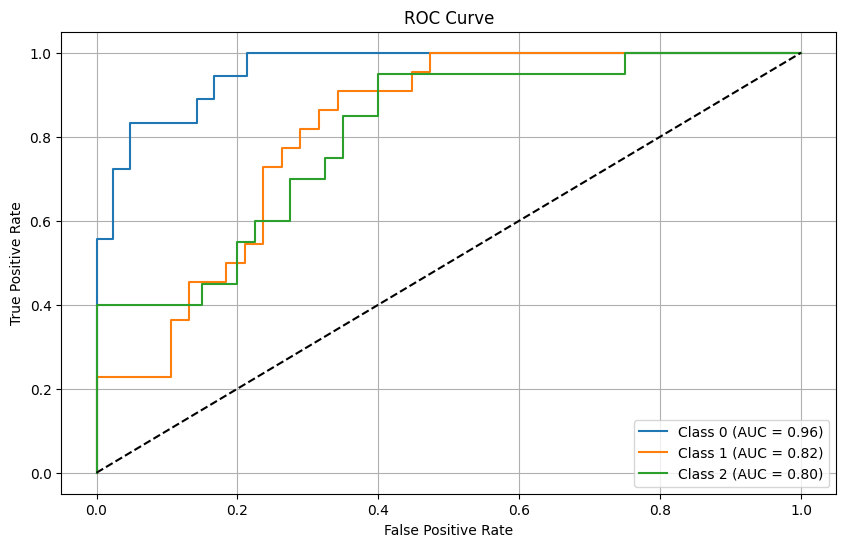

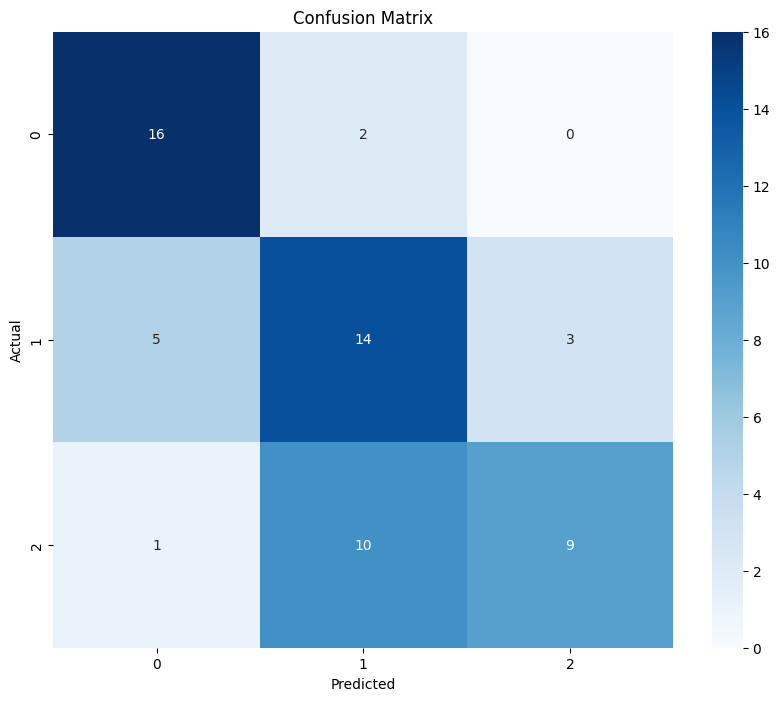

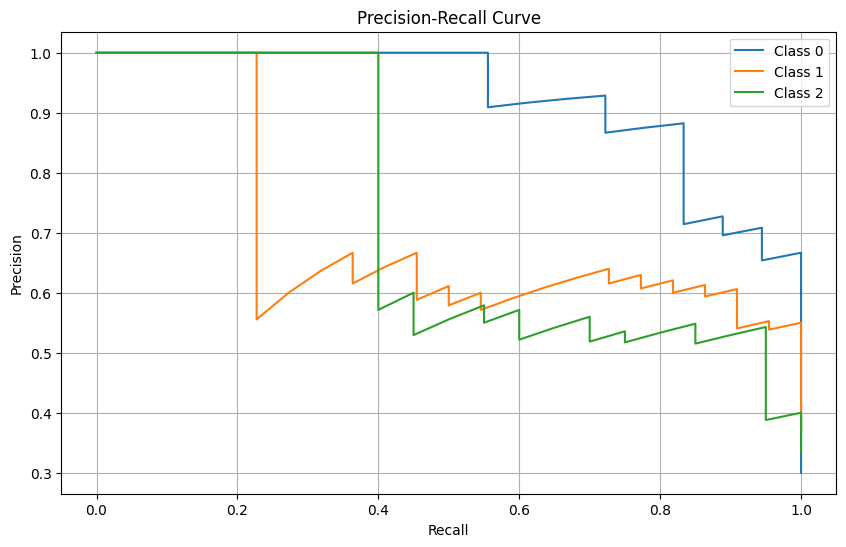

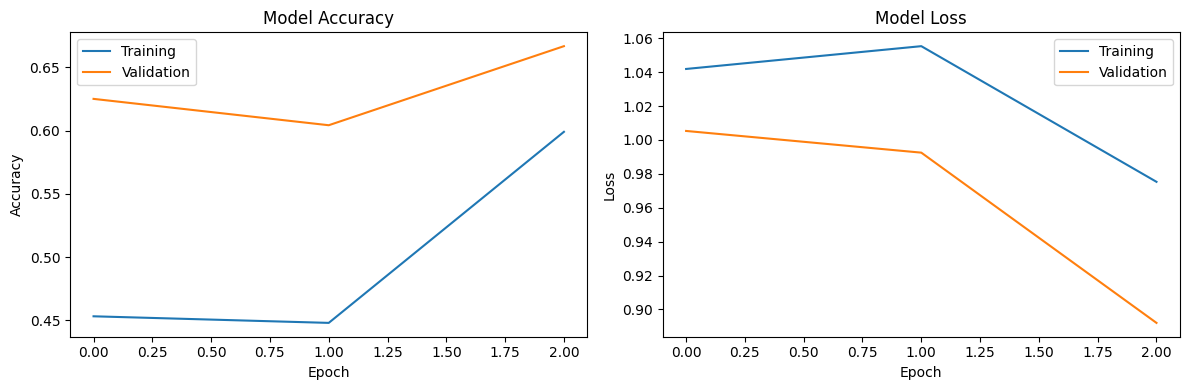


Final Model Performance:
Test Accuracy: 0.6500
F1 Score: 0.6414


In [5]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Generate predictions for visualization
Y_test_pred_prob = final_model.predict(X_test_scaled)
Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)

# Convert labels for visualization
Y_test_one_hot = tf.keras.utils.to_categorical(Y_test, num_classes=3)

# Visualizations
def plot_all_visualizations(Y_test, Y_test_one_hot, Y_test_pred, Y_test_pred_prob, history):
    # ROC Curve
    plt.figure(figsize=(10, 6))
    for i in range(3):
        y_true_binary = (np.argmax(Y_test_one_hot, axis=1) == i).astype(int)
        y_score = Y_test_pred_prob[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(10, 6))
    for i in range(3):
        precision, recall, _ = precision_recall_curve(Y_test_one_hot[:, i], Y_test_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

    # Training Curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Generate all visualizations
plot_all_visualizations(Y_test, Y_test_one_hot, Y_test_pred, Y_test_pred_prob, history)

# Print final metrics
print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy_score(Y_test, Y_test_pred):.4f}")
print(f"F1 Score: {f1_score(Y_test, Y_test_pred, average='weighted'):.4f}")

In [6]:
# Save the trained model
# model.save("resnet_cnn_stratified_kfold.h5")
print("Model saved as resnet_cnn_stratified_kfold.h5")

Model saved as resnet_cnn_stratified_kfold.h5


#End